In [1]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'rlops',
    'password': 'jTeL85L!',
    'options': f'-c search_path=rl',
}

In [2]:
import os
import sys
sys.path.append('..')

from alphazero import config
import stable_rad_config

In [3]:
# Load the game buffer
with psycopg2.connect(**dbparams) as conn:
    df = pd.read_sql_query("""
    select * from stablepsj_game where experiment_id = %s
    """, conn, params=(config.experiment_id,))

In [4]:
# Load the policy training history
log = pd.read_csv(os.path.join(config.checkpoint_filepath, 'log.csv'))
log['time'] = pd.to_datetime(log.time)

Text(0, 0.5, 'Reward')

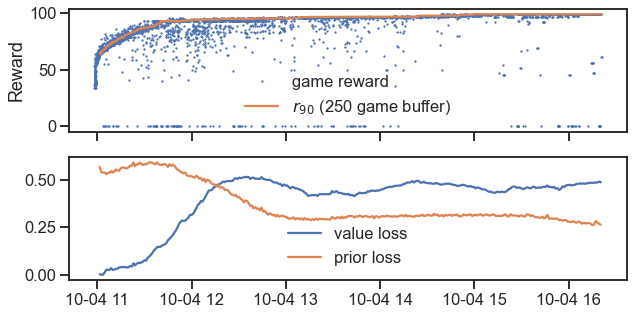

In [5]:
fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(10, 5))

axs[0].plot(df.time, df.real_reward, '.', ms=2.5, label='game reward')
axs[0].plot(df.time, df.real_reward.rolling(250).quantile(.9), label='$r_{90}$ (250 game buffer)')

axs[1].plot(log.time, log.policy_wrapper_loss, label='value loss')
axs[1].plot(log.time, log.policy_wrapper_1_loss, label='prior loss')

axs[1].legend()
axs[0].legend()

axs[0].set_ylabel('Reward')

In [6]:
df.tail(20)

,id,time,experiment_id,gameid,real_reward,final_smiles
3278,9905,2020-10-04 16:20:29.682885,0005,907469de,99.144240,C=CC(=C(O)[C]=N)C(C)C
3279,9906,2020-10-04 16:20:35.532377,0005,2aba0816,61.143436,CC(=[N])C(=CN)NC=CN
3280,9907,2020-10-04 16:20:41.535892,0005,4877925b,99.144240,C=CC(=C(O)[C]=N)C(C)C
3281,9908,2020-10-04 16:20:46.776028,0005,ae44485d,99.144240,C=CC(=C(O)[C]=N)C(C)C
3282,9909,2020-10-04 16:20:56.236964,0005,aeb7ff48,61.143436,CC(=[N])C(=CN)NC=CN


In [14]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**dbparams) as conn:
    rew_df = pd.read_sql_query("select * from stablepsj_reward", conn)

rew_df.shape

(489621, 7)

In [15]:
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    orig_costs = np.array(costs)
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return orig_costs[is_efficient_mask]
    else:
        return is_efficient

In [16]:
rew_df.head()

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index
0,[C]#CC#N,2020-10-01 18:49:39.179745,48.074257,C,22.521230,0.488940,1
1,C[C]=C=N,2020-10-01 18:49:40.270978,55.539494,C,31.348166,0.516173,2
2,C=C=[C]O,2020-10-01 18:49:40.757469,56.670605,C,28.143957,0.429467,1
3,NC[C]=O,2020-10-01 18:49:40.759254,47.112630,C,29.438765,0.646523,0
4,[C]#COO,2020-10-01 18:49:40.970014,48.538612,C,22.561136,0.480450,1


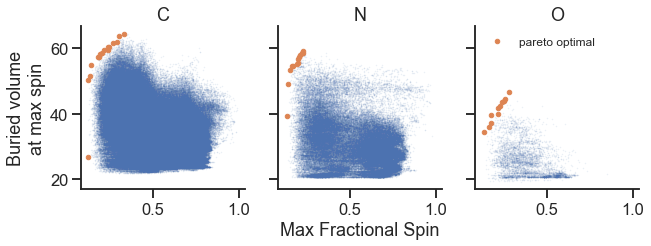

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O']):
    
    vals = rew_df[rew_df.atom_type == atom][['max_spin', 'buried_vol']].dropna()
    vals['buried_vol'] *= -1
    pareto_index = is_pareto_efficient(vals.values, return_mask=False)
    pareto_points = vals.iloc[pareto_index]
    optimal += [vals.iloc[pareto_index].index]
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1)
    
    ax.plot(pareto_points['max_spin'], -pareto_points['buried_vol'], '.', label='pareto optimal')
    
    ax.set_title(atom)

    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12)
sns.despine()    

In [18]:
rew_df.iloc[optimal[0]]

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index
261901,C=CC(=C(N)[C]=N)N(C)O,2020-10-03 09:15:30.213646,97.875410,C,57.254097,0.187574,0
261915,[CH]=C1C2=C(C)NC3=C=C2C13,2020-10-03 09:15:30.571119,97.856490,C,54.906555,0.141001,2
264125,CC1=C=C2CC=[C]C(C)=C12,2020-10-03 09:16:32.055170,98.127235,C,57.226738,0.181990,0
268972,C=CC(=C(N)[C]=N)N(C)N,2020-10-03 09:19:33.432212,98.381065,C,58.097890,0.194336,0
350483,C=[C]c1c#cncc1N=N,2020-10-04 05:06:20.824215,94.796460,C,51.547413,0.135019,5
353848,N=[C]c1c#cncc1N=O,2020-10-04 05:07:31.792222,94.022964,C,50.337116,0.126283,5
440593,C=[C]C1=C=C(C#N)C1=C,2020-10-04 05:45:11.162888,70.698380,C,26.940306,0.124838,5
466822,CNC(=C(O)[C]=N)C(C)C,2020-10-04 06:05:23.954751,98.177050,C,61.557457,0.267608,0
482025,C=NC(=C(O)[C]=O)C(C)C,2020-10-04 06:37:16.411563,97.481230,C,59.414420,0.238664,0
486195,C=NC1=C(O)[C]=CC1(C)C,2020-10-04 07:16:55.742596,97.915820,C,60.329650,0.248277,0
